# Ejercicio 3: Predicción de una serie de tiempo caótica

En este ejercicio se pide entrenar y evaluar un predictor para el sistema no-lineal [Mackey-Glass](https://en.wikipedia.org/wiki/Mackey-Glass_equations)

Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = \beta \frac{ y(t-\tau)}{1 + y(t-\tau)^{n}} - \gamma y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

En esta tarea nos limitaremos en estudiar el caso con $n=10$, $\gamma = 0.1$ y $\beta = 0.2$

El valor del parámetro $\tau$ modifica el comportamiento dinámico del sistema, en particular se tiene que

- $\tau = 17$ el sistema tiene un comportamiento debilmente caótico
- $\tau = 30$ el sistema tiene un comportamiento fuertemente caótico

La ecuación de diferencial anterior fue propuesta por Michael Mackey and Leon Glass en 1977 como modelo para procesos fisiológicos asociados a la [homeostasis](https://es.wikipedia.org/wiki/Homeostasis)

El código adjunto a esta tarea genera la serie de tiempo en función 

Se generan 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar, los siguientes 250 puntos para calibrar los hiperparámetros y los últimos 250 para evaluar y comparar los filtros

<IPython.core.display.Javascript object>


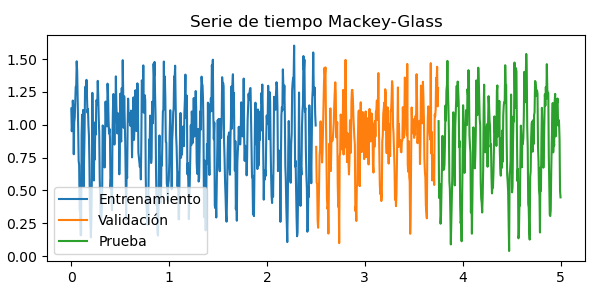

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
from mackey import MackeyGlass

# Puede calcular el error medio cuadrático normalizado usando:
NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

# Gráfico
plt.close('all')
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=30.)
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.plot(t_train, y_train, label='Entrenamiento')
ax.plot(t_valid, y_valid, label='Validación')
ax.plot(t_test, y_test, label='Prueba')
ax.set_title('Serie de tiempo Mackey-Glass');
ax.legend();


## (45%) Predicción con algoritmo LMS

1. Describa en detalle el algoritmo LMS e implemente un predictor a un paso basado en el **algoritmo LMS normalizado**
1. Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\mu$ y $L$ que minimiza el NMSE en el conjunto de validación. Se recomienda realizar un barrido logarítmo para $\mu$. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.
1. Repita el paso anterior para el caso $\tau = 30$.
1. Compare los resultados obtenidos con cada serie de tiempo ($\tau=17$ y $\tau=30$). Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados.

---

### Algoritmo LMS:
El algoritomo LMS (Least Mean Square) es un algoritmo simple computacionalmente ampliamente utilizado en filtros adaptativos.
- No requiere conocimiento estadístico del proceso.
- Tampoco se requiere calcular e invertir la matriz de correlación.
- Se entrena de manera recursiva y online.

Su uso consiste en imitar algún filtro deseado mediante la búsqueda de coeficientes que puedan minimizar el error instantáneo de la señal. Esto se logra mediante 2 procesos:
- Proceso de filtrado: calcula la salida generada.
- Proceso adaptativo: actualiza los coeficientes.

---

In [2]:
#Filtro LMS normalizado
class Filtro_NLMS:
    
    def __init__(self, L, mu, delta=1e-6):
        self.L = L
        self.w = np.zeros(shape=(L+1, ))
        self.mu = mu
        self.delta = delta
        
    def update(self, un, dn):
        unorm = np.dot(un, un) + self.delta
        error = dn - np.dot(self.w, un)
        self.w += 2*self.mu*error*(un/unorm)
        return np.dot(self.w, un)

In [78]:
#FILTRO NLMS
#Buscamos L y mu óptimos obteniendo el NMSE mínimo en el conjunto de validación con cada combinación de parámetros
def NLMS(L, mus, y_train, y_valid):
    y_pred = np.zeros(shape=(len(y_train), len(mus)))
    NMSE_values = []
    #NMSE_min = 999999
    #mu_min = 0
    
    for i, mu in enumerate(mus):
        
        #Entrenamiento del filtro en el conjunto de entrenamiento [0, 500]
        filtro = Filtro_NLMS(L, mu)
        for k in range(L+1, len(y_train)):
            y_pred[k,i] = filtro.update(y_train[k-L-1:k][::-1], y_train[k])

        #Error NMSE en el conjunto de validación [500:750]
        error = NMSE(y_valid, y_pred[:250, i])
        NMSE_values.append(error)
        print('{0:2} {1:25} {2:25}'.format(L, mu, error))
        
        #if(NMSE_min > error):
            #NMSE_min = error
            #mu_min = mu
            
    print("------------------------------------------------------")
    #print("NMSE mínimo = ", NMSE_min) 
    #print("L = ", L)
    #print("\u03BC = ", mu_min, "\n\n------------------------------------------------------")
    
    return min(NMSE_values)

#Parámetros
tau = [17., 30.]
L = [5, 10, 20, 30]

#Barrido logarítimo de mu
mus =  np.logspace(-2, 0, num=10)

for i in tau:
    NMSE_values = []
    (t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=i)
    print("------------------------------------------------------")
    print("                      \u03C4 =", i,"\n------------------------------------------------------")
    print(' {0:24} {1:18} {2}'.format("L","\u03BC","NMSE"), "\n------------------------------------------------------")
    for j in L:
        NMSE_values.append(NLMS(j, mus, y_train, y_valid))
    print("           NMSE mínimo =", min(NMSE_values),"\n------------------------------------------------------\n\n\n");

------------------------------------------------------
                      τ = 17.0 
------------------------------------------------------
 L                        μ                  NMSE 
------------------------------------------------------
 5                      0.01         714.7568120792397
 5      0.016681005372000592         591.0398273983723
 5      0.027825594022071243        500.28952373860574
 5      0.046415888336127774        425.40091916226055
 5        0.0774263682681127        356.49423230047677
 5        0.1291549665014884        290.26391842863376
 5       0.21544346900318834         234.5688444483378
 5        0.3593813663804626        205.23279823936028
 5        0.5994842503189409         262.5641376047801
 5                       1.0         5992.373175449127
------------------------------------------------------
10                      0.01         690.5086383236759
10      0.016681005372000592          549.018806041293
10      0.027825594022071243         

### Filtro NLMS

---

#### Para $\tau = 17$:

- $L = 5$: tiene el mímimo NMSE de todas las combinaciones de parámetros y también el peor con valores de $\approx 205$ y $\approx 5992$ respectivamente y como estamos usando el criterio de minimizar el NMSE, aquí encontramos los parámetros óptimos.

- $L = 10$: tiene el mejor NMSE promedio ya que los errores suelen ser bajo y no fluctuan tanto como el caso anterior, pero nuevamente, como estamos usando el criterio de minimizar el NMSE, no es óptimo.

- $L = 20$: tiene errores bastante bajos/aceptables, pero aún así son más altos que en el caso anterior y por lo tanto no es óptimo.

- $L = 30$: resulta ser el peor caso ya que tiene errores muy elevados/malos.

Entonces, la combinación de parámetros óptima de $L$ y $\mu$ bajo el criterio de minimizar el NMSE en el conjunto de validación para $\tau = 17$ es:
- $L = 5$
- $\mu = 0.3593813663804626$

En donde se obtiene un $NMSE$ de $205.23279823936028$.

---

#### Para $\tau = 30$:


- $L = 5$: tiene NMSE bastante bajos, pero, aparte de no encontrar el NSME mínimo acá, se encuentra el NSME con el valor más alto de todas las combinaciones posibles con un NSME de $\approx 27503$ por lo que resulta ser un mal caso.

- $L = 10$: tiene el NMSE mínimo con $\approx 439$ por lo que aquí encontramos los parámetros óptimos.

- $L = 20$: tiene un NMSE bastante bajos/aceptables, pero al no encontrarse el mínimo acá, no es el caso óptimo.

- $L = 30$: podría considerarse como el peor caso, ya que, tiene NMSE bastante elevados/malos.

Entonces, la combinación de parámetros óptima de $L$ y $\mu$ bajo el criterio de minimizar el NMSE en el conjunto de validación para $\tau = 30$ es:
- $L = 10$
- $\mu = 0.046415888336127774$

En donde se obtiene un $NSME$ de $439.061167567548 $.

---

En general y como era de esperar, en la serie débilmente caótica ($\tau = 17$) se observaron errores mucho más bajos que en la serie fuertemente caótica ($\tau = 30$).

En ambas series se observó que en los extremos $\mu = 0.1$ y $\mu = 1$ es en donde suele haber un NSME más alto, sobre todo en el último caso.

---

<IPython.core.display.Javascript object>


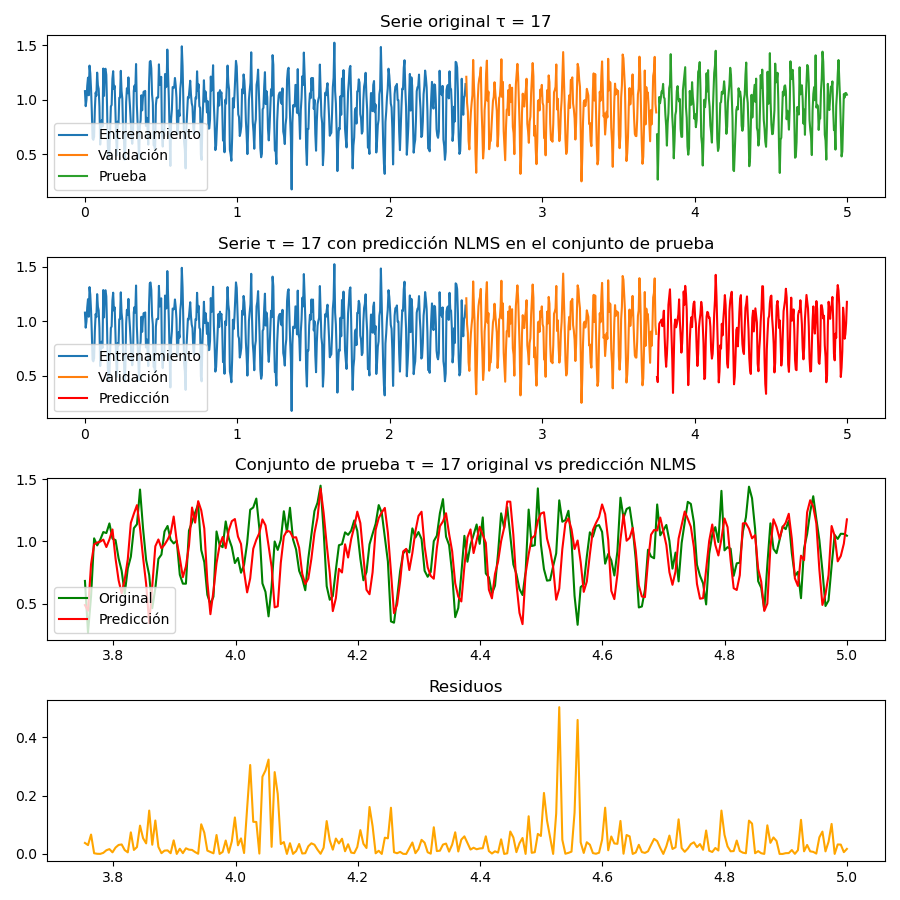

In [42]:
#Filtro NLMS con serie tau = 17
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=17.)
y_NLMS_17 = np.zeros(shape=(len(y_train)))

#Parámetros óptimos
L = 5
mu = 0.3593813663804626

#Creamos el filtro con los parámetros óptimos
NLMS_17 = Filtro_NLMS(L, mu)
for k in range(L+1, len(y_train)):
    y_NLMS_17[k] = NLMS_17.update(y_train[k-L-1:k][::-1], y_train[k])

plt.close('all')
fig, ax = plt.subplots(4, figsize=(9, 9), tight_layout=True)

#Original
ax[0].plot(t_train, y_train, label='Entrenamiento')
ax[0].plot(t_valid, y_valid, label='Validación')
ax[0].plot(t_test, y_test, label='Prueba')
ax[0].set_title('Serie original \u03C4 = 17'); #tau = \u03C4
ax[0].legend(loc=3);

#Predicción
ax[1].plot(t_train, y_train, label='Entrenamiento')
ax[1].plot(t_valid, y_valid, label='Validación')
ax[1].plot(t_test, y_NLMS_17[250:], label='Predicción', color='red')
ax[1].set_title('Serie \u03C4 = 17 con predicción NLMS en el conjunto de prueba');
ax[1].legend(loc=3);

#Original vs predicción
ax[2].plot(t_test, y_test, label='Original', color='green')
ax[2].plot(t_test, y_NLMS_17[250:], label='Predicción', color='red')
ax[2].set_title('Conjunto de prueba \u03C4 = 17 original vs predicción NLMS')
ax[2].legend(loc=3)

#Residuos
ax[3].plot(t_test, (y_test - y_NLMS_17[250:])**2, color='orange')
ax[3].set_title('Residuos');

#### Resultados gráficos para $\tau = 17:$

- Predice de buena manera al observar el contorno verde vs el rojo. Es bastante estable a lo largo del tiempo.

- Suele mantener errores bajos a lo largo del tiempo. Se observan algunos picos elevados en aproximadamente $4.1$ y $4.5$ segundos pero éstos no suelen ser altos ya que no pasan de $0.4$.

<IPython.core.display.Javascript object>


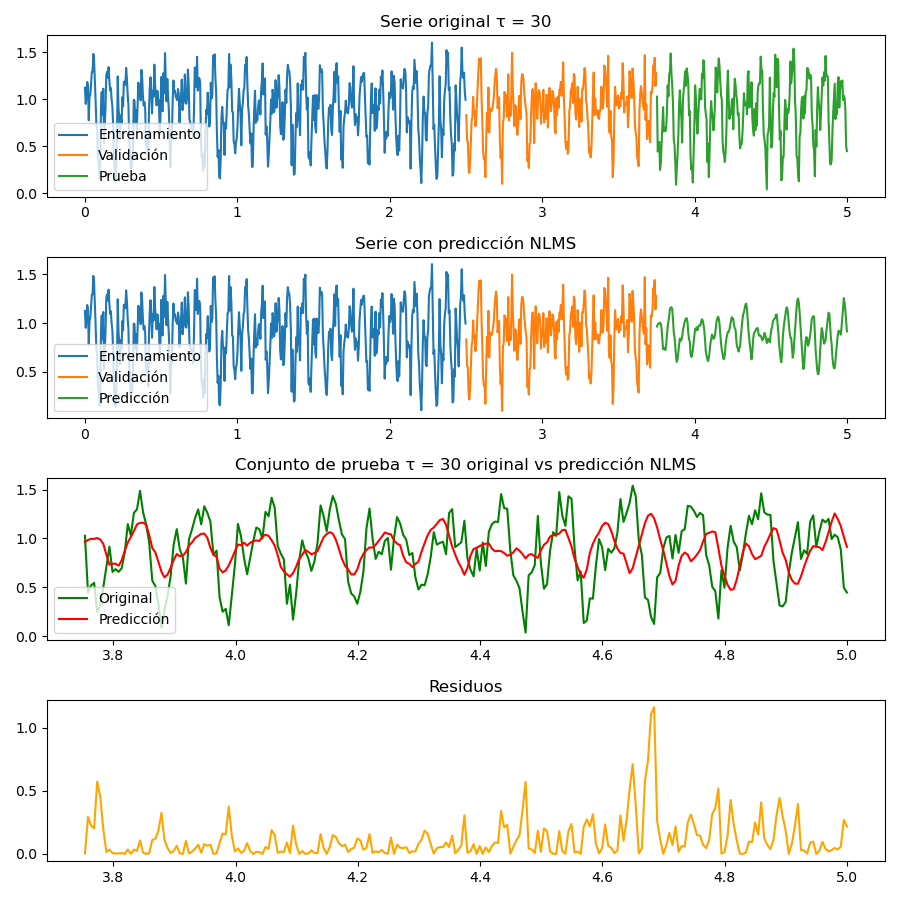

In [43]:
#Filtro NLMS con serie tau = 30
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=30.)
y_NLMS_30 = np.zeros(shape=(len(y_train)))

#Parámetros óptimos
L = 20
mu = 0.046415888336127774

#Creamos el filtro con los parámetros óptimos
NLMS_30 = Filtro_NLMS(L, mu)
for k in range(L+1, len(y_train)):
    y_NLMS_30[k] = NLMS_30.update(y_train[k-L-1:k][::-1], y_train[k])


plt.close('all')
fig, ax = plt.subplots(4, figsize=(9, 9), tight_layout=True)

#Original
ax[0].plot(t_train, y_train, label='Entrenamiento')
ax[0].plot(t_valid, y_valid, label='Validación')
ax[0].plot(t_test, y_test, label='Prueba')
ax[0].set_title('Serie original \u03C4 = 30')
ax[0].legend(loc=3);

#Predicción
ax[1].plot(t_train, y_train, label='Entrenamiento')
ax[1].plot(t_valid, y_valid, label='Validación')
ax[1].plot(t_test, y_NLMS_30[250:], label='Predicción')
ax[1].set_title('Serie con predicción NLMS')
ax[1].legend(loc=3);

#Original vs predicción
ax[2].plot(t_test, y_test, label='Original', color='green')
ax[2].plot(t_test, y_NLMS_30[250:], label='Predicción', color='red')
ax[2].set_title('Conjunto de prueba \u03C4 = 30 original vs predicción NLMS')
ax[2].legend(loc=3)

#Residuos
ax[3].plot(t_test, (y_test - y_NLMS_30[250:])**2, color='orange')
ax[3].set_title('Residuos');

#### Resultados gráficos para $\tau = 30:$

- No logra predecir bien, se observa que sigue la tendencia pero falla al predecir los cambios bruscos. No logra tomar valores menores a $\approx 0.5$ ni valores mayores a $\approx 1.1$ necesarios para que se parezca a la serie original y esto se ve reflejado en el contorno verde vs el rojo.

- Tiene errores (picos) a lo largo de todo el tiempo y específicamente se observa un pico muy elevado en aproximadente $4.7$ segundos con un error que llega a más de $1.0$.

---

Como es de esperar, predecir la serie fuertemente caótica es mucho más complicado que la débilmente caótica.

---

## (45%) Predicción con algoritmo RLS

1. Describa en detalle el algoritmo RLS e implemente un predictor a un paso basado en el algoritmo RLS. Resalte las diferencias con el algoritmo LMS
1. Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\beta$ y $L$ que minimiza el NMSE en el conjunto de validación. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.
1. Repita el paso anterior para el caso $\tau = 30$
1. Compare los resultados obtenidos con cada serie de tiempo. Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

---

#### Algoritmo RLS:
El algoritmo RLS (Recursive Least Squares) es un algoritmo que, al igual que el algoritmo LMS, se utiliza en filtros adaptativos.

Consiste en encontrar el mínimo error histórico (suma de errores desde la muestrea inicial a la actual) de forma recursiva.

Diferencias con el algoritmo LMS:
- El algoritmo RLS converge mucho más rápido que el algoritmo LMS.
- Busca minimizar el error histórico mientras que el algoritmo LMS minimiza el error instantáneo.

Se pueden utilizar dos soluciones para actualizar los pesos: la solución cerrada y la recursiva. En este caso utilizaremos la recursiva, por lo tanto, el algoritmo en resumen hace lo siguiente:

- Inicializa
 - $\Phi_0^{-1} = \lambda I$ 
 - $\textbf{w}_0 = 0$


- Para $n \in [1, \infty]$

 - Calcula la ganancia: $\textbf{k}_n =  \frac{\Phi_{n-1}^{-1} \textbf{u}_n }{\beta + \textbf{u}_n^T \Phi_{n-1}^{-1} \textbf{u}_n}$

 - Calcula el error: $e_n = d_n - \textbf{u}_n^T  \textbf{w}_{n-1}$

 - Actualiza el error de pesos: $\textbf{w}_n = \textbf{w}_{n-1} + \textbf{k}_n e_n$

 - Actualiza el inverso de la matriz de correlación: $\Phi_{n}^{-1} = \beta^{-1} \Phi_{n-1}^{-1} - \beta^{-1} \textbf{k}_n \textbf{u}_n^T \Phi_{n-1}^{-1}$

---

In [44]:
#FILTRO RLS
class Filtro_RLS:
    
    def __init__(self, L, beta, lamb=1e-2):
        self.L = L
        self.w = np.zeros(shape=(L+1, ))
        self.beta = beta
        self.lamb = lamb
        self.Phi_inv = lamb*np.eye(L+1)
        
    def update(self, un, dn):
        # Cálculo de la ganancia
        pi = np.dot(un.T, self.Phi_inv)
        kn = pi.T/(self.beta + np.inner(pi, un))
        # Actualizar el vector de pesos
        error = dn - np.dot(self.w, un)
        self.w += kn*error
        # Actualizar el inverso de Phi
        self.Phi_inv = (self.Phi_inv - np.outer(kn, pi))*self.beta**-1
        return np.dot(self.w, un)

In [81]:
#FILTRO RLS
#Buscamos L y beta óptimos obteniendo el NMSE mínimo en el conjunto de validación con cada combinación de parámetros
def RLS(L, betas, y_train, y_valid):
    y_pred = np.zeros(shape=(len(y_train), len(betas)))
    NMSE_values = []
    
    for i, beta in enumerate(betas):
        
        #Entrenamiento del filtro en el conjunto de entrenamiento [0, 500]
        filtro = Filtro_RLS(L, beta)
        for k in range(L+1, len(y_train)):
            y_pred[k,i] = filtro.update(y_train[k-L-1:k][::-1], y_train[k])

        #Error NMSE en el conjunto de validación [500:750]
        error = NMSE(y_valid, y_pred[:250, i])
        NMSE_values.append(error)
        print('{0:2} {1:25} {2:25}'.format(L, beta, error))
            
    print("------------------------------------------------------")
    return min(NMSE_values)

#Parámetros
tau = [17., 30.]
L = [5, 10, 20, 30]

#Beta
betas = np.linspace(0.6, 1.0, 20)

for i in tau:
    NMSE_values = []
    (t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=i)
    print("------------------------------------------------------")
    print("                      \u03C4 =", i,"\n------------------------------------------------------")
    print(' {0:24} {1:18} {2}'.format("L","\u03B2","NMSE"), "\n------------------------------------------------------")
    for j in L:
        NMSE_values.append(RLS(j, betas, y_train, y_valid))
    print("       NMSE mínimo =", min(NMSE_values),"\n------------------------------------------------------\n\n\n")

------------------------------------------------------
                      τ = 17.0 
------------------------------------------------------
 L                        β                  NMSE 
------------------------------------------------------
 5                       0.6        2182.9863349682296
 5        0.6210526315789473        233.22689585434534
 5        0.6421052631578947        290.63678688847915
 5        0.6631578947368421          235.018620315647
 5        0.6842105263157895        249.54405807245365
 5        0.7052631578947368         239.4215286220905
 5        0.7263157894736842         2569.521788167379
 5        0.7473684210526316         251.6641344322899
 5        0.7684210526315789        248.42487499465608
 5        0.7894736842105263         263.0591874625943
 5        0.8105263157894737        270.78524388070923
 5         0.831578947368421        274.09129978424056
 5        0.8526315789473684        281.36746222839133
 5        0.8736842105263158        2

30        0.6421052631578947         774.5707814494564
30        0.6631578947368421         773.5787995411471
30        0.6842105263157895         772.4935507846062
30        0.7052631578947368         771.3174023951489
30        0.7263157894736842         770.0319758414429
30        0.7473684210526316          768.583589866449
30        0.7684210526315789         766.9427284297282
30        0.7894736842105263         764.9322084173766
30        0.8105263157894737         762.5107158488912
30         0.831578947368421         759.4369676335324
30        0.8526315789473684         755.3615121700852
30        0.8736842105263158         749.7424466493923
30         0.894736842105263          741.666651535155
30        0.9157894736842105         730.2111859394817
30        0.9368421052631579         714.2700800757249
30        0.9578947368421052         686.8491532394729
30        0.9789473684210526         624.2865504184077
30                       1.0         549.2096320622991
----------

---
### Filtro RLS

---

#### Para $\tau = 17$:

- $L = 5$: tiene el NMSE mínimo de todas las combinaciones posibles observadas con un valor de $\approx 233$, por lo tanto, acá encontramos los parámetros óptimos.

- $L = 10$: tiene NMSE bastante bajos/aceptables, pero, al no encontrarse el mínimo, no es el caso óptimo que estamos buscando.

- $L = 20$: a partir de acá los NMSE empiezan a ser más altos y peores.

- $L = 30$: es el peor caso ya que tiene los NMSE más altos.

Entonces, la combinación de parámetros óptima de $L$ y $\beta$ bajo el criterio de minimizar el NMSE en el conjunto de validación para $\tau = 17$ es:

- $L = 5$
- $\beta = 0.6210526315789473$

En donde se obtiene un $NMSE$ de $233.22689585434534$.

---

#### Para $\tau = 30$:

- $L = 5$: tiene NMSE bastante bajos/aceptables, pero, al no encontrarse el mínimo, no es el caso óptimo que estamos buscando.

- $L = 10$: tiene el NMSE mínimo de todas las combinaciones posibles observadas con un valor de $\approx 460$, por lo tanto, acá encontramos los parámetros óptimos.

- $L = 20$: a partir de acá los NMSE empiezan a ser más altos y peores.

- $L = 30$: es el peor caso ya que tiene los NMSE más altos.

Entonces, la combinación de parámetros óptima de $L$ y $\beta$ bajo el criterio de minimizar el NMSE en el conjunto de validación para $\tau = 30$ es:
- $L = 10$
- $\beta = 1.0$

En donde se obtiene un $NSME$ de $460.09104631267235$.

---

En general y como era de esperar, en la serie débilmente caótica ($\tau = 17$) se observaron errores más bajos que en la serie fuertemente caótica ($\tau = 30$).

A diferencia del filtro NLMS, los NMSE del filtro RLS son más estables y no suelen tener errores exageradamente elevados.

---

<IPython.core.display.Javascript object>


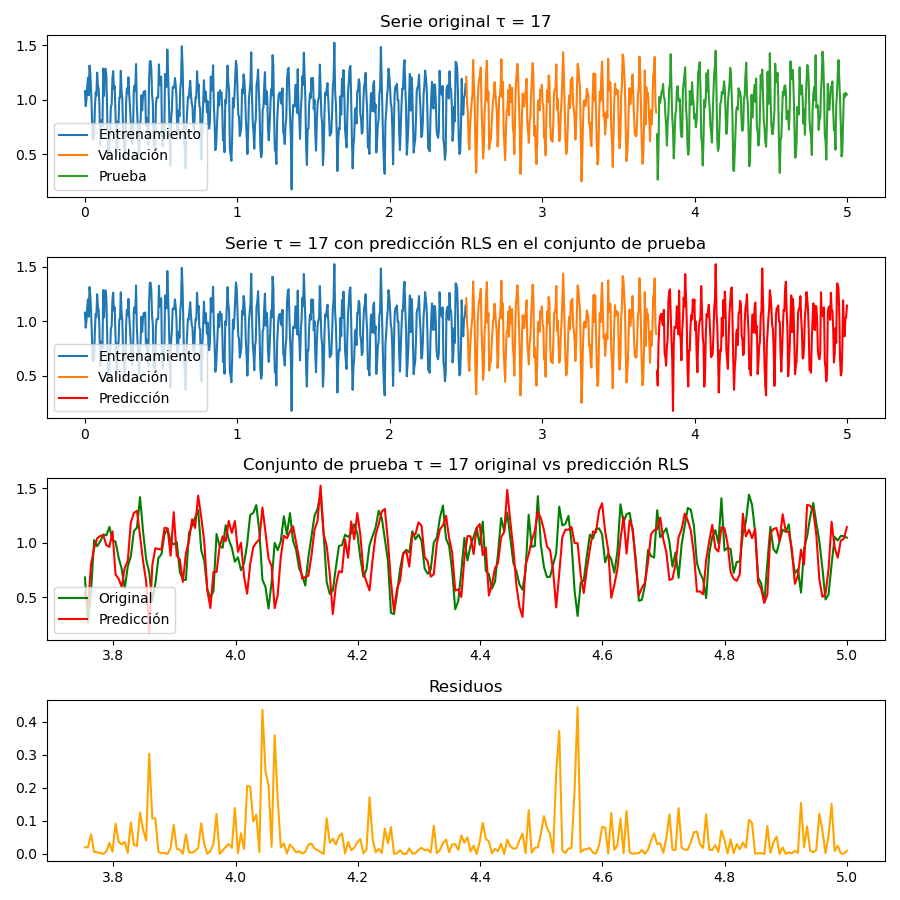

In [54]:
#Filtro RLS con serie tau = 17
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=17.)
y_RLS_17 = np.zeros(shape=(len(y_train)))

L = 5
beta = 0.6210526315789473

RLS_17 = Filtro_RLS(L, beta)
for k in range(L+1, len(y_train)):
    y_RLS_17[k] = RLS_17.update(y_train[k-L-1:k][::-1], y_train[k])
    
plt.close('all')
fig, ax = plt.subplots(4, figsize=(9, 9), tight_layout=True)

#Original
ax[0].plot(t_train, y_train, label='Entrenamiento')
ax[0].plot(t_valid, y_valid, label='Validación')
ax[0].plot(t_test, y_test, label='Prueba')
ax[0].set_title('Serie original \u03C4 = 17'); #tau = \u03C4
ax[0].legend(loc=3);

#Predicción
ax[1].plot(t_train, y_train, label='Entrenamiento')
ax[1].plot(t_valid, y_valid, label='Validación')
ax[1].plot(t_test, y_RLS_17[250:], label='Predicción', color='red')
ax[1].set_title('Serie \u03C4 = 17 con predicción RLS en el conjunto de prueba');
ax[1].legend(loc=3);

#Original vs predicción
ax[2].plot(t_test, y_test, label='Original', color='green')
ax[2].plot(t_test, y_RLS_17[250:], label='Predicción', color='red')
ax[2].set_title('Conjunto de prueba \u03C4 = 17 original vs predicción RLS')
ax[2].legend(loc=3)

#Residuos
ax[3].plot(t_test, (y_test - y_RLS_17[250:])**2, color='orange')
ax[3].set_title('Residuos');

#### Resultados gráficos para $\tau = 17:$

- Predice muy bien si observamos el contorno verde vs el rojo y se desestabiliza un poco en $\approx 3.9$, $\approx 4.1$ y $\approx 4.5$ segundos. Ésto se ve reflejado en la gráfica de residuos.

- Mantiene errores bajos a lo largo del tiempo a excepción de los intervalos en donde se desestabiliza produciendo 4 picos elevados con un error de $\approx 0.4$.

<IPython.core.display.Javascript object>


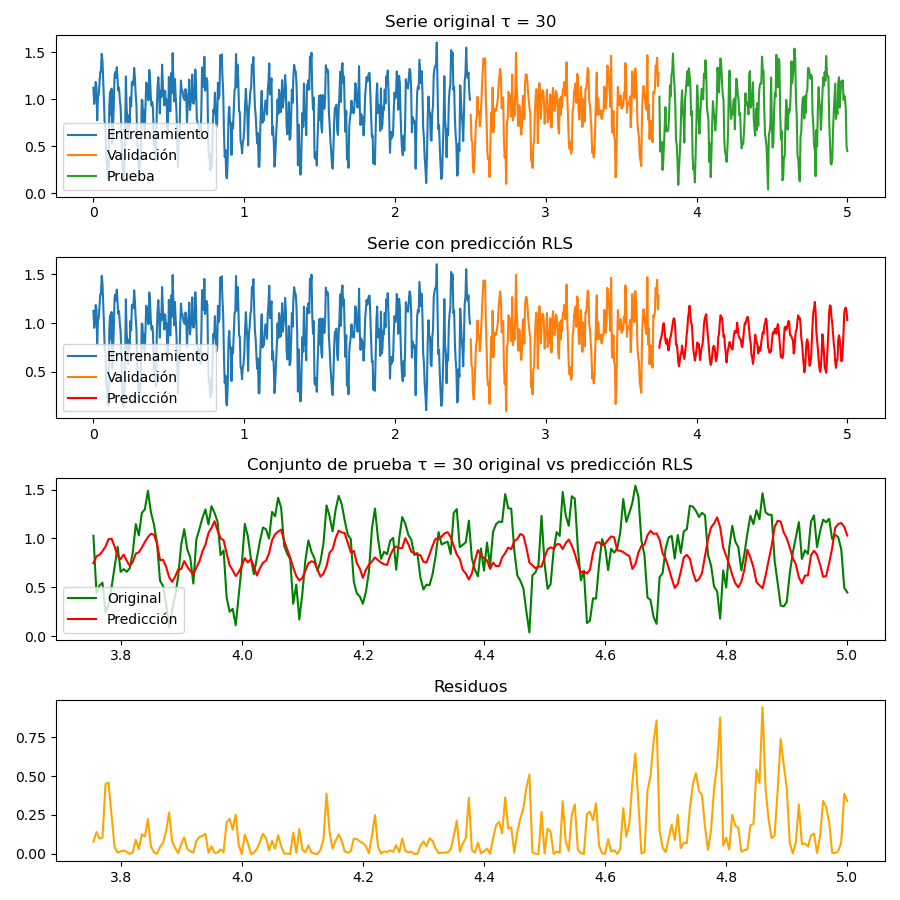

In [74]:
#Filtro RLS con serie tau = 30
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=30.)
y_RLS_30 = np.zeros(shape=(len(y_train)))

#Parámetros óptimos
L = 10
beta = 1.0

#Creamos el filtro con los parámetros óptimos
RLS_30 = Filtro_RLS(L, beta)
for k in range(L+1, len(y_train)):
    y_RLS_30[k] = RLS_30.update(y_train[k-L-1:k][::-1], y_train[k])

plt.close('all')
fig, ax = plt.subplots(4, figsize=(9, 9), tight_layout=True)

#Original
ax[0].plot(t_train, y_train, label='Entrenamiento')
ax[0].plot(t_valid, y_valid, label='Validación')
ax[0].plot(t_test, y_test, label='Prueba')
ax[0].set_title('Serie original \u03C4 = 30')
ax[0].legend(loc=3);

#Predicción
ax[1].plot(t_train, y_train, label='Entrenamiento')
ax[1].plot(t_valid, y_valid, label='Validación')
ax[1].plot(t_test, y_RLS_30[250:], label='Predicción', color='red')
ax[1].set_title('Serie con predicción RLS')
ax[1].legend(loc=3);

#Original vs predicción
ax[2].plot(t_test, y_test, label='Original', color='green')
ax[2].plot(t_test, y_RLS_30[250:], label='Predicción', color='red')
ax[2].set_title('Conjunto de prueba \u03C4 = 30 original vs predicción RLS')
ax[2].legend(loc=3)

#Residuos
ax[3].plot(t_test, (y_test - y_RLS_30[250:])**2, color='orange')
ax[3].set_title('Residuos');

#### Resultados gráficos para $\tau = 30:$

- Se observa que intenta seguir la tendencia, pero se desestabiliza a lo largo de todo el tiempo si observamos la línea roja vs la verde.
- En la gráfica de residuos se observan picos a lo largo de todo el tiempo, pero a partir de los $\approx 4.4$ segundos, se comienza a desestabilizar mucho produciendo muchos picos con errores de hasta $\approx 0.75$.

---

Como es de esperar y al igual que en el filtro NLMS, predecir la serie fuertemente caótica es mucho más complicado que la débilmente caótica.

---

## (10%) Comparación entre LMS y RLS

1. Compare el mejor predictor LMS y RLS en el conjunto de test en términos de la calidad de la predicción y la velocidad a la que sigue los cambios. Comente y discuta.

<IPython.core.display.Javascript object>


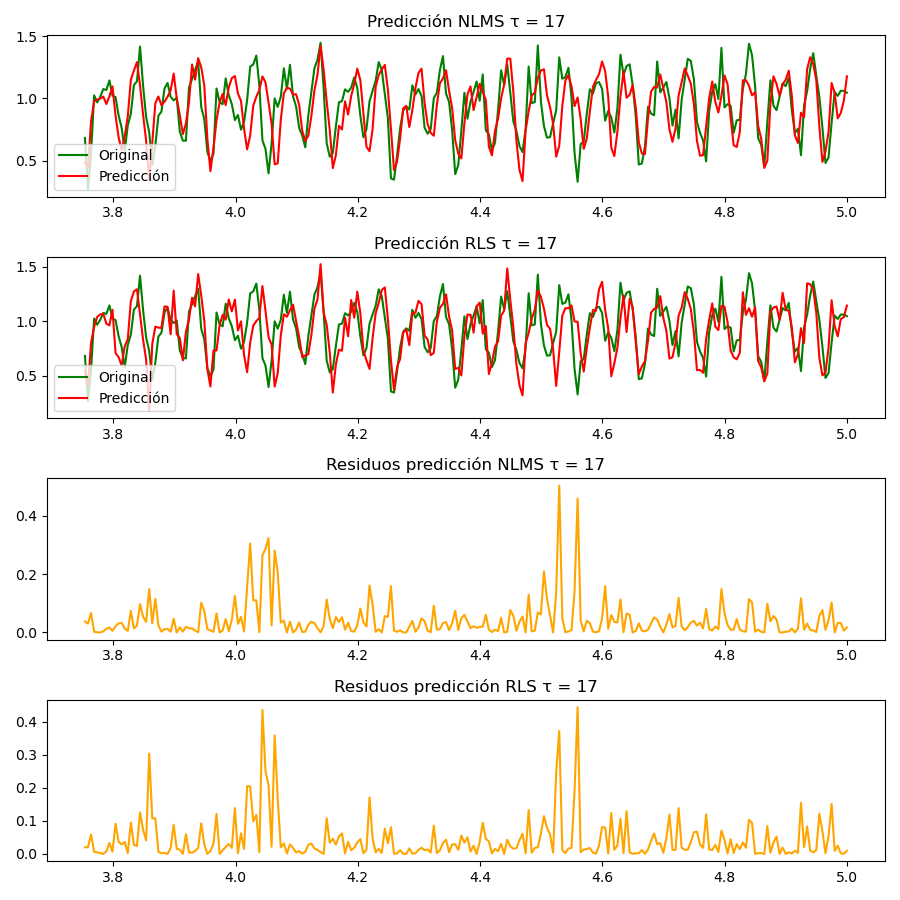

In [75]:
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=17.)

fig, ax = plt.subplots(4, figsize=(9, 9), tight_layout=True)

#NLMS tau 17
ax[0].plot(t_test, y_test, label='Original', color='green')
ax[0].plot(t_test, y_NLMS_17[250:], label='Predicción', color='red')
ax[0].set_title('Predicción NLMS \u03C4 = 17')
ax[0].legend(loc=3)

#RLS tau 17
ax[1].plot(t_test, y_test, label='Original', color='green')
ax[1].plot(t_test, y_RLS_17[250:], label='Predicción', color='red')
ax[1].set_title('Predicción RLS \u03C4 = 17')
ax[1].legend(loc=3)

#error cuadrático NLMS tau 17
ax[2].plot(t_test, (y_test - y_NLMS_17[250:])**2, color='orange')
ax[2].set_title('Residuos predicción NLMS \u03C4 = 17');

#error cuadrático RLS tau 17
ax[3].plot(t_test, (y_test - y_RLS_17[250:])**2, color='orange')
ax[3].set_title('Residuos predicción RLS \u03C4 = 17');

---

El filtro RLS logra predecir de una mejor manera que el filtro NLMS si observamos las líneas verdes y rojas ya que sigue los cambios bruscos de mucho mejor manera, pero, suele desestabilizarse un poco más y hace que tenga un NMSE un poco más elevado.

Ambos filtros son bastante parejos, predicen de buena forma y por lo tanto su calidad es buena. Es posible que bajo otro criterio la predicción podría ser aún más fiel a la original, pero en este caso, gana el filtro NLMS ya que tiene en NMSE mínimo.

---

<IPython.core.display.Javascript object>


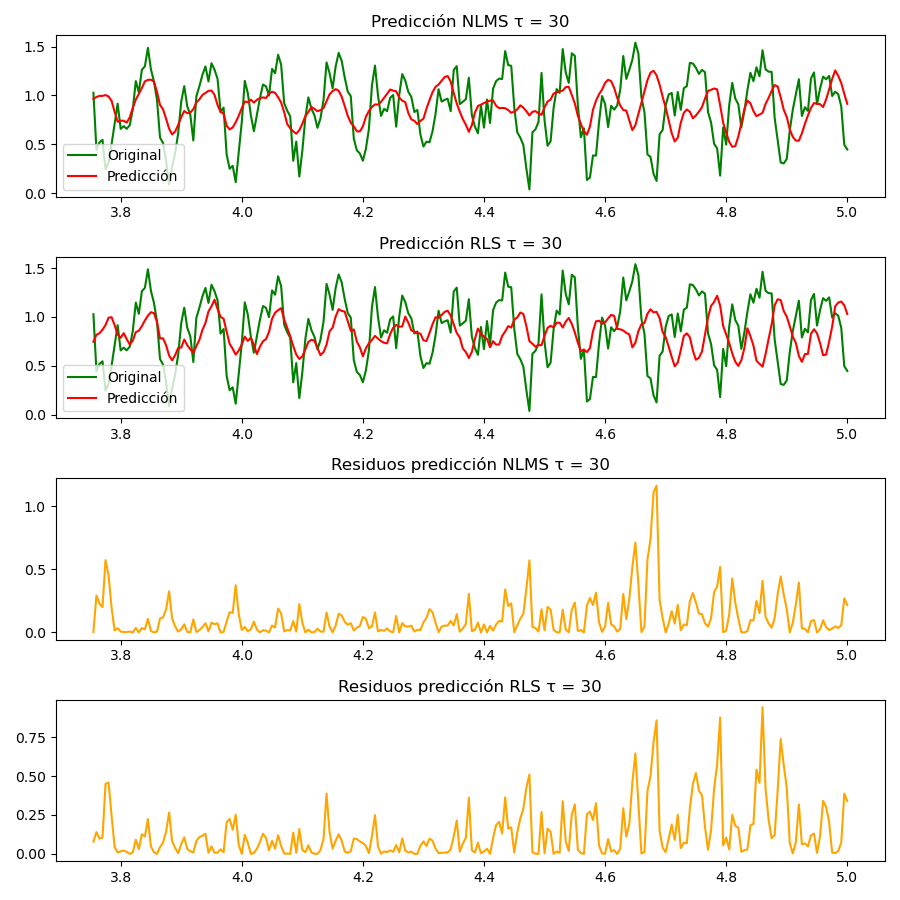

In [76]:
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=30.)
fig, ax = plt.subplots(4, figsize=(9, 9), tight_layout=True)

#NLMS tau 30
ax[0].plot(t_test, y_test, label='Original', color='green')
ax[0].plot(t_test, y_NLMS_30[250:], label='Predicción', color='red')
ax[0].set_title('Predicción NLMS \u03C4 = 30')
ax[0].legend(loc=3)

#RLS tau 30
ax[1].plot(t_test, y_test, label='Original', color='green')
ax[1].plot(t_test, y_RLS_30[250:], label='Predicción', color='red')
ax[1].set_title('Predicción RLS \u03C4 = 30')
ax[1].legend(loc=3)

#error cuadrático NLMS tau 30
ax[2].plot(t_test, (y_test - y_NLMS_30[250:])**2, color='orange')
ax[2].set_title('Residuos predicción NLMS \u03C4 = 30');

#error cuadrático RLS tau 30
ax[3].plot(t_test, (y_test - y_RLS_30[250:])**2, color='orange')
ax[3].set_title('Residuos predicción RLS \u03C4 = 30');

---

El filtro RLS sigue los cambios bruscos de mucho mejor manera que el filtro NLMS, pero al desestabilizarse mucho más a partir de los $\approx 4.4$ segundos hace que tenga un NMSE más elevado que el filtro NLMS.

La calidad para ambos casos es bastante mediocre, pero de cierta forma era de esperarse al tratarse de una serie fuertemente caótica.

Si bien el filtro RLS logra seguir mucho más rápido los cambios bruscos a diferencia del filtro NLMS, estamos bajo el criterio de minimizar el NMSE, por lo que el filtro NLMS es que que gana al tener un un NMSE más bajo.

---

Si hubieramos usando un criterio de, por ejemplo, minimizar el NMSE promedio, gana el filtro RLS al ya que sus NSME no fluctuan tanto entre sí manteniendo valores bajos a diferencia del filtro NLMS.